In [3]:
!pip install jovian --upgrade --quiet

#Cats and Dogs Classification using Feed Forward and Convolutional Neural Networks in PyTorch

--- 


---


<img src='https://media.giphy.com/media/Rdx8SHjHhiVUI/giphy.gif'
style="width:1000px; float: left; margin: 0 0px 0px 0px;"></img> 


---





---



### This project will be running and  comparing between the feed forward neural network and ResNet architectures.

- Train and validation datasets will both be taken from the training_set and test_set respectively 
- Same batch size will be used for both models which is = 16
- output size is 2
- dataset used is normalized and augmented




In [4]:
# Project name used for jovian.commit
project_name = 'zerotogans-course-project'

In [5]:
#install dependencies
!pip install kaggle -q
!pip install torch
# !pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet

### Choose and download the dataset

---



- through kaggle API
- While downloading the dataset, you will be asked to provide your Kaggle username and credentails, which you can obtain using the "Create New API Token" button on your account page on Kaggle. Upload the kaggle.json notebook using the files tab or enter the username and key manually when prompted.

In [6]:
#create a kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission; Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
#or copy API command
!kaggle datasets download -d chetankv/dogs-cats-images

 98% 425M/435M [00:03<00:00, 186MB/s]
100% 435M/435M [00:03<00:00, 143MB/s]


- Datasets can also be downloaded using opendatasets




dataset_url = 'https://www.kaggle.com/chetankv/dogs-cats-images'

download Kaggle datasets using the opendatsets then import as od
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.download(dataset_url)


- OR by downloading your own dataset using urllib library and python code or helper codes


In [8]:
#Unzip dataset to content folder.
from zipfile import ZipFile
with ZipFile('./dogs-cats-images.zip', 'r') as zip: 
    zip.extractall(path='./dogs-cats-images') #
    print('file extraction done.')

file extraction done.


In [9]:
import os
print(os.listdir("../content"))

#Set default path from ../content folder
path = '../content/dogs-cats-images/dataset'

# data_dir = 'cats_and_dogs/train'
data_dir = path + '/training_set' 
data_dir

['.config', 'dogs-cats-images', 'kaggle.json', 'dogs-cats-images.zip', 'sample_data']


'../content/dogs-cats-images/dataset/training_set'

### Check and verify the training sets

In [10]:
cat_files = os.listdir(data_dir + "/cats")
print('No. of training examples for cats:', len(cat_files))
print(cat_files[:5])

No. of training examples for cats: 4000
['cat.1455.jpg', 'cat.454.jpg', 'cat.3184.jpg', 'cat.567.jpg', 'cat.1052.jpg']


In [11]:
dog_files = os.listdir(data_dir + "/dogs")
print('No. of training examples for dogs:', len(dog_files))
print(dog_files[:5])

No. of training examples for dogs: 4000
['dog.367.jpg', 'dog.2716.jpg', 'dog.2903.jpg', 'dog.139.jpg', 'dog.1365.jpg']



### Define transforms properties for both train and test datasets and load the 

---


images data using ImageFolder from torchvision

In [12]:
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

batch_size=16 #lowest batch size accepted by both models without throwing an error

#data_dir = path + /training_set

#to view original image
dataset_no_tfms = transforms.Compose([transforms.ToTensor()])
dataset_raw = datasets.ImageFolder(data_dir, transform=dataset_no_tfms) #training_set, NO transforms

#before normalization, get the mean and std dev----needs images to be of same size
dataset_tfms = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()]) # totensor only, transforms.Resize(255),  transforms.CenterCrop(224), 
dataset = datasets.ImageFolder(data_dir, transform=dataset_tfms) #training_set, NO transforms
dataset_dl = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

#compute for mean and std dev for normalization stats
def stats(loader):
  # var[x] = e[x**2] - e[x]**2
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0

  for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3]) # (N, C, H, W) where N is the number of examples in our batch, #of channels, height and width.
    num_batches += 1
  mean = channels_sum/num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5 #---square root
  return mean, std

mean, std = stats(dataset_dl)
print(mean,std)

tensor([0.4884, 0.4506, 0.4123]) tensor([0.2592, 0.2512, 0.2520])


use the mean and std dev results obtained above for the train and val transforms

In [13]:
#set transforms for the training data and testing data
#experiment: try to set both resize and centercrop to the same value (ex 128)

stats = ((mean),(std)) ##mean and std dev values for the 3 channels RGB respectively

train_tfms = transforms.Compose([transforms.RandomRotation(45),
                                      transforms.RandomResizedCrop(224), #if this param is used, it will need to be added in the validation dataset as well or it will throw an error in size
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
                                      transforms.ToTensor(),
                                      transforms.Normalize(*stats,inplace=True)])  #place normalize at the end after totensor
#after normalization
# *n.b. if validation sets will be used, it should not have transforms other than totensor and normal stats because it is used for reporting the performance of the model
val_tfms = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(), transforms.Normalize(*stats,inplace=True)])  #place normalize at the end after totensor 
                                      #transforms.RandomRotation(45), 

# #data_dir = path + /training_set
train_ds= datasets.ImageFolder(data_dir, transform=train_tfms) #training_set
val_ds = datasets.ImageFolder(path + '/test_set', transform=val_tfms)

In [14]:
print('Train Dataset Length: ' + str(len(dataset)), '\nClasses: ' + str(dataset.classes))

Train Dataset Length: 8000 
Classes: ['cats', 'dogs']


In [15]:
img, label = dataset[4000] #before normalization
print(img.shape, label)
img
# label = 1 (dog), 0 (cat)

torch.Size([3, 224, 224]) 1


tensor([[[0.5647, 0.5451, 0.5255,  ..., 0.0078, 0.0039, 0.0275],
         [0.5529, 0.5373, 0.5176,  ..., 0.0039, 0.0078, 0.0078],
         [0.5137, 0.5020, 0.5020,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.5098, 0.7412, 0.8980,  ..., 0.8588, 0.8706, 0.8745],
         [0.5137, 0.7373, 0.8902,  ..., 0.8549, 0.8667, 0.8627],
         [0.5098, 0.7294, 0.8902,  ..., 0.8510, 0.8549, 0.8588]],

        [[0.5059, 0.4902, 0.4745,  ..., 0.0000, 0.0039, 0.0235],
         [0.5020, 0.4863, 0.4706,  ..., 0.0039, 0.0118, 0.0039],
         [0.4863, 0.4745, 0.4784,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.5137, 0.7490, 0.9059,  ..., 0.8471, 0.8627, 0.8667],
         [0.5176, 0.7451, 0.8980,  ..., 0.8392, 0.8471, 0.8471],
         [0.5137, 0.7373, 0.8980,  ..., 0.8314, 0.8353, 0.8392]],

        [[0.3961, 0.3882, 0.3725,  ..., 0.0039, 0.0000, 0.0039],
         [0.3922, 0.3843, 0.3647,  ..., 0.0078, 0.0039, 0.0000],
         [0.3686, 0.3647, 0.3647,  ..., 0.0039, 0.0039, 0.

### Visualize the images on the dataset and dataloader

---

In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'


def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    print(img.shape)

- Visualize the same image (dataset and train_ds) first with no transforms then with different transforms definition

Label:  cats (0)
torch.Size([3, 375, 499])


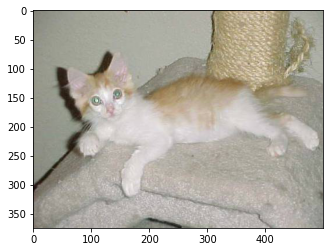

In [17]:
show_example(*dataset_raw[9]) #image before normalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  cats (0)
torch.Size([3, 224, 224])


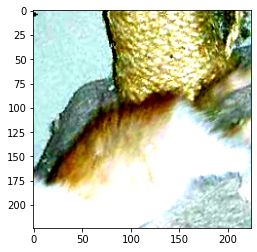

In [18]:
show_example(*train_ds[9]) #with other transform definitions and normalization

Label:  dogs (1)
torch.Size([3, 499, 327])


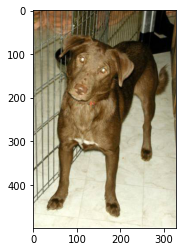

In [19]:
show_example(*dataset_raw[4000]) #image before normalization

Label:  dogs (1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


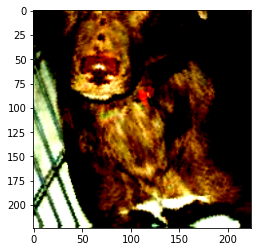

In [20]:
show_example(*train_ds[4000]) #with other transform definitions and normalization

In [ ]:
dataset_url = 'https://www.kaggle.com/chetankv/dogs-cats-images'
jovian.log_dataset(dataset_url=dataset_url)
# jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

### Dataloaders take a specific amount of data and squeezes it into a matrix

---

- define dataloaders for train and validation sets to be used by the 2 models

In [ ]:
# from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)   #no shuffling needed, no gradients calculated, not much GPU RAM needed

In [ ]:
# test train_dl
images, labels = next(iter(train_dl))
plt.imshow(images[0].permute(1, 2, 0))
plt.colorbar() #before denormalization

### Denormalize displays the images with pixels in the range (0,1).

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1) #N,C,H,W
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means #opposite of normalization where we subtract the mean and divide by the std dev

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:
from torchvision.utils import make_grid
show_batch(train_dl)

In [ ]:
jovian.commit(project=project_name, environment=None, privacy='secret')



---



---


## Define an ImageClassificationBase Class and functions to be used by the models
---
Define a Loss Function
- Cross-entropy -  a classification loss function used to predict a discrete value (in this case, cat or dog)
  - BCE Loss is mainly used for binary classification models, that is having only 2 classes
  - Neural Network should have a sigmoid activation function when using BCELoss() 
  - Sigmoid functionlimits the output to a range between 0 and 1.
- other function that can be used in classification:
  - torch.nn.NLLLoss - applied only on models with the softmax function as an output activation layer

In [ ]:
import torch.nn as nn
import torch.nn.functional as F 

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss; used for image classification model
        acc = accuracy(out, labels)           # Calculate accuracy; eval metric used for image classification model
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
@torch.no_grad() # gradients calculated, evaluation becomes faster
def evaluate(model, val_loader):
    model.eval() #tells the model that we are evaluating not training; dropout is turned off
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD): #stochastic gradient descent ( adam)
    torch.cuda.empty_cache() # removes any stale data or existing tensors which are not currently being used from the GPU memory
    history = [] # contains the epoch x epoch results
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader)) # steps_per_epoch - # of batches
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradient
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() #calculates the lr depending on the onecyclepolicy and sets the lr inside the optimizer.
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#check if available
torch.cuda.is_available() 

Get default device and move tensors to device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    print('grid.shape',  make_grid(images, nrow=16).shape) #nrow = # specifies the # of elements in a row
    break

Plot losses and accuracies

In [ ]:
import numpy as np

def plot_all(history, lr=False, name=''):
    if lr==True:  #will run if lr is specified to true
      fig, ax = plt.subplots(1,4,  figsize = (18,4))

      lrs = np.concatenate([x.get('lrs', []) for x in history])
      ax[3].plot(lrs, '-cx')
      ax[3].set_xlabel('Batch no.')
      ax[3].set_ylabel('Learning rate')
      ax[3].set_title('Learning Rate vs. Batch no.')
    else:
      fig, ax = plt.subplots(1,3,  figsize = (18,4))

    losses = [x['val_loss'] for x in history]
    ax[0].plot(losses, '-x')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].set_title('Loss vs. No. of epochs')

    accuracies = [x['val_acc'] for x in history]
    ax[1].plot(accuracies, '-x')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].set_title('Accuracy vs. No. of epochs')

    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax[2].plot(train_losses, '-bx')
    ax[2].plot(val_losses, '-rx')
    ax[2].set_xlabel('epoch')
    ax[2].set_ylabel('loss')
    ax[2].legend(['Training', 'Validation'])
    ax[2].set_title('Loss vs. No. of epochs')

    fig.tight_layout()
    plt.savefig(name+'.png')

### Define Model classes for logistic regression using feed forward and convolutional neural networks


---


- Feed Forward Neural Network

In [ ]:
input_size = 3*224*224
output_size = 2

In [ ]:
class CatsDogsModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 1052)    # hidden layer
        self.linear2 = nn.Linear(1052, 526)         # hidden layer 2
        self.linear3 = nn.Linear(526, 128)          # 3
        self.linear4 = nn.Linear(128, 32)          # 4
        self.linear5 = nn.Linear(32, 16)    # 5 
        self.linear6 = nn.Linear(16, out_size) #output layer

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Get intermediate outputs using hidden layers then apply activation function
        out = self.linear1(out)
        out = F.relu(out) #non-linearity 
       
        out = self.linear2(out)
        out = F.relu(out)
        # out = torch.sigmoid(out) 

        out = self.linear3(out)
        # out = torch.sigmoid(out)
        out = F.relu(out) 
        
        out = self.linear4(out)
        # out = torch.sigmoid(out)
        out = F.relu(out) 

        out = self.linear5(out)
        out = torch.sigmoid(out) 
        # out = F.relu(out)

        out = self.linear6(out)   # Get predictions using output layer
        return out

- Convolutional using ResNet9

In [ ]:
def conv_block(in_channels, out_channels, pool=False): #- in a residual block, you CANNOT CHANGE THE # of output channels
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), #always use kernel_size=3 and padding=1
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers) # * layers - we take @ element of the layers (nn.Conv2d(in_channels) list and pass that as a separate argument to nn.Sequential

    '''
    1st argument:
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    2nd argument:
    nn.BatchNorm2d(out_channels), 
    3rd argument:
    nn.ReLU(inplace=True)]
    4th argument: (if pool=True)
    if pool: layers.append(nn.MaxPool2d(2))
    '''

class ResNet9(ImageClassificationBase):  # ResNet9 - can be used with any kind of image classification model
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #batch size = 32 x 3 x 256 x 256
        self.conv1 = conv_block(in_channels, 526) #in_channels =  3 x 256 x 256; shape = 32x256x256.  ----->pool=False
        self.conv2 = conv_block(526, 128, pool=True) #32 x 128 x 128.  ----> pool= True     ---------> MaxPool2d(2)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) #64 x 128 x 128
        
        self.conv3 = conv_block(128, 32, pool=True) #256 x 64 x 64 --->pool=True
        self.conv4 = conv_block(32, 16, pool=True) #512 x 32 x 32--->pool=True
        self.res2 = nn.Sequential(conv_block(16, 16), conv_block(16, 16)) #512 x 16 x 16
        
        self.classifier = nn.Sequential(nn.MaxPool2d(16), #perform max pooling  512 x 1 x 1. -------->MaxPool2d(32)
                                        nn.Flatten(), # 512. ------removed 1 x 1
                                        nn.Dropout(0.2), # avoiding over-fitting technique; randomly pick certain elements from the feature map; randomly pick 20% of the value and set to 0; 
                                        #the model will have to make predictions with the values with 80% each time. forces the model to generalize better.
                                        #selectively hiding certain values from the model
                                        # dropout is ONLY done during training
                                        #512
                                        nn.Linear(16, num_classes)) #2
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

###Move dataloaders to appropriate devices

---
- Need to define devices and devicedataloaders separately because if the same dataloader is used, it will throw in an error: 


```
RuntimeError: CUDA out of memory.....
```




---



CatsDogsModel (Feed Forward)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

ResNet9 (Convolutional Neural Network)

In [ ]:
device2 = get_default_device()
device2

In [ ]:
train_dl2 = DeviceDataLoader(train_dl, device2)
val_dl2 = DeviceDataLoader(val_dl, device2)

### Train the Model

---
- same parameters used for both models on '**first training ru**n'

- CatsDogsModel
***********************************************
***********************************************
Change the following parameters on succeeding run

- loss function - nn.CrossEntropyLoss
- opt_func = torch.optim.SGD
- no. of hidden layers - 4
- activation functions - ReLu and sigmoid


***********************************************
***********************************************

In [ ]:
model = to_device(CatsDogsModel(input_size, output_size), device)

In [ ]:
for t in model.parameters():
  print(t.shape) #prints out 1 wt and 1 bias matrix for each of the 2 hidden layers

In [ ]:
#check the validation loss and accuracy with inital set of weights
history = [evaluate(model, val_dl)]
history

In [ ]:
# CatsDogsModel
epochs = 50
max_lr = 0.03 #0.01
grad_clip = 0.1
weight_decay = 1e-3 #0.1 0.01 to 10
opt_func = torch.optim.SGD #Adam will not improve accuracy; bounces back and forth
layers = "5 layers (1052, 526, 128, 32, 16)"

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

#beeps when fit finishes
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
# plot and save fig
plot_all(history, lr=True, name='feedforward')

Final test accuracy and loss

In [ ]:
acc = evaluate(model, val_dl)
test_acc = acc['val_acc']
test_loss = acc['val_loss']
test_acc, test_loss

In [ ]:
train_time = '' #previous run[5] 4min 42s; [50] 40min 40s; 41min 59s

### Save model and log metrics and hyperparameters for CatsDogsModel

In [ ]:
CatsDogsModel = {
      'arch': 'FeedForwardNeuralNetwork '+ layers, 
      'epochs': epochs, 
      'lr': max_lr, 
      'scheduler' : 'one-cycle', 
      'weight_decay' : weight_decay, 
      'grad_clip' :grad_clip,
      'opt' : opt_func.__name__}

CatsDogsModel_metrics = {
      'val_loss' : history[-1]['val_loss'], 
      'val_acc' : history[-1]['val_acc'],
      'train_loss' : history[-1]['train_loss'],
      'time' : train_time}
      
#print CatsDogsModel and metrics dict
for k, v in CatsDogsModel.items():
  print(k, v)

for k, v in CatsDogsModel_metrics.items():
  print(k, v)

In [ ]:
torch.save(model.state_dict(), 'catsdogs-feedforward.pth')

In [ ]:
jovian.reset() 
jovian.log_hyperparams(CatsDogsModel)
jovian.log_metrics(CatsDogsModel_metrics)

In [ ]:
jovian.commit(project=project_name, environment=None, privacy='secret', file='feedforward.png') #save file to jovian

- ResNet9

***********************************************
***********************************************
try to change on succeeding run:

- double the # of epochs
- network architecture
- change lr fr 1cyclepolicy, bn, dropout value
- change augmentations


***********************************************

In [ ]:
model2 = to_device(ResNet9(3, 2), device2)
# model2

In [ ]:
for t in model2.parameters():
  print(t.shape) #prints out 1 wt and 1 bias matrix for each of the 2 hidden layers

torch.Size([526, 3, 3, 3])
torch.Size([526])
torch.Size([526])
torch.Size([526])
torch.Size([128, 526, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([32, 128, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([2, 16])
torch.Size([2])


In [ ]:
#check the validation loss and accuracy with inital set of weights
history2 = [evaluate(model2, val_dl2)]
history2

[{'val_acc': 0.5039682388305664, 'val_loss': 0.6936666369438171}]

In [ ]:
# ResNet9
epochs2 = 50 
max_lr2 = 0.03
grad_clip2 = 0.1
weight_decay2 = 1e-4 
opt_func2 = torch.optim.SGD

In [ ]:
%%time
history2 += fit_one_cycle(epochs2, max_lr2, model2, train_dl2, val_dl2, 
                             grad_clip=grad_clip2, 
                             weight_decay=weight_decay2, 
                             opt_func=opt_func2)

#beeps when fit finishes
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Epoch [0], last_lr: 0.00151, train_loss: 0.7271, val_loss: 0.7005, val_acc: 0.5238
Epoch [1], last_lr: 0.00244, train_loss: 0.6817, val_loss: 0.6810, val_acc: 0.5694
Epoch [2], last_lr: 0.00395, train_loss: 0.6824, val_loss: 0.6558, val_acc: 0.5947


In [ ]:
#plot and save fig
plot_all(history2, lr =True, name='resnet')

Final test accuracy and loss

In [ ]:
acc2= evaluate(model2, val_dl)
test_acc2 = acc2['val_acc']
test_loss2 = acc2['val_loss']
test_acc2, test_loss2

In [ ]:
train_time2 = '' #previous run[5] 40min

### Save model and log metrics and hyperparameters for ResNet9

In [ ]:
ResNet9 = {
      'arch': 'ResNet9 ', 
      'epochs': epochs2, 
      'lr': max_lr2, 
      'scheduler' : 'one-cycle', 
      'weight_decay' : weight_decay2, 
      'grad_clip' :grad_clip2,
      'opt' : opt_func2.__name__}

ResNet9_metrics = {
      'val_loss' : history2[-1]['val_loss'], 
      'val_acc' : history2[-1]['val_acc'],
      'train_loss' : history2[-1]['train_loss'],
      'time' : train_time2}

#print ResNet9 and metrics dict
for k, v in ResNet9.items():
  print(k, v)

for k, v in ResNet9_metrics.items():
  print(k, v)

In [ ]:
torch.save(model2.state_dict(), 'catsdogs-resnet9.pth')

In [ ]:
#no reset, to preserve the previous hyperparams and log for catsdogsmodel
jovian.log_hyperparams(ResNet9)
jovian.log_metrics(ResNet9_metrics)

In [ ]:
jovian.commit(project=project_name, environment=None, privacy='secret', file='resnet.png') #save file to jovian

NameError: ignored

###Test with individual images

---

In [ ]:
def predict_image(img, model, device):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [ ]:
len(val_ds)

In [ ]:
img, label = val_ds[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))

lbl = train_ds.classes[label]
m1 = predict_image(img, model, device)
m2 = predict_image(img, model2, device2)

print('Label:', lbl,'\nCatsDogsModel Prediction:', m1, '\nResNet9 Prediction:', m2)

if lbl == m1 and lbl != m2:
  print('\nCatsDogsModel predicted correctly')
elif lbl == m2 and lbl != m1:
  print('\nResNet9 predicted correctly')
elif lbl != m1 and lbl != m2:
  print('\nBoth models predicted wrong')
else:
  print('\nBoth models predicted correctly')

In [ ]:
img, label = val_ds[899]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))

lbl = train_ds.classes[label]
m1 = predict_image(img, model, device)
m2 = predict_image(img, model2, device2)

print('Label:', lbl,'\nCatsDogsModel Prediction:', m1, '\nResNet9 Prediction:', m2)

if lbl == m1 and lbl != m2:
  print('\nCatsDogsModel predicted correctly')
elif lbl == m2 and lbl != m1:
  print('\nResNet9 predicted correctly')
elif lbl != m1 and lbl != m2:
  print('\nBoth models predicted wrong')
else:
  print('\nBoth models predicted correctly')

In [ ]:
img, label = val_ds[1999]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))

lbl = train_ds.classes[label]
m1 = predict_image(img, model, device)
m2 = predict_image(img, model2, device2)

print('Label:', lbl,'\nCatsDogsModel Prediction:', m1, '\nResNet9 Prediction:', m2)

if lbl == m1 and lbl != m2:
  print('\nCatsDogsModel predicted correctly')
elif lbl == m2 and lbl != m1:
  print('\nResNet9 predicted correctly')
elif lbl != m1 and lbl != m2:
  print('\nBoth models predicted wrong')
else:
  print('\nBoth models predicted correctly')

In [ ]:
img, label = val_ds[1000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))

lbl = train_ds.classes[label]
m1 = predict_image(img, model, device)
m2 = predict_image(img, model2, device2)

print('Label:', lbl,'\nCatsDogsModel Prediction:', m1, '\nResNet9 Prediction:', m2)

if lbl == m1 and lbl != m2:
  print('\nCatsDogsModel predicted correctly')
elif lbl == m2 and lbl != m1:
  print('\nResNet9 predicted correctly')
elif lbl != m1 and lbl != m2:
  print('\nBoth models predicted wrong')
else:
  print('\nBoth models predicted correctly')

### References

---



- [kaggle dataset](https://www.kaggle.com/mmoreaux/audio-cats-and-dogs)
- [loading image data on kaggle](https://www.kaggle.com/leifuer/intro-to-pytorch-loading-image-data)
- [Loss Functions on neptune.ai](https://neptune.ai/blog/pytorch-loss-functions)
- [Calculate Mean and Standard Deviation of data](https://www.youtube.com/watch?v=y6IEcEBRZks&t=291s)



<!-- - [Machine Learning for audio: Urban Sound Identification](https://www.youtube.com/watch?v=SFBfzr0wZIc&t=199s)
- [librosa.org](https://librosa.org/doc/latest/index.html) -->

In [ ]:
jovian.commit(project=project_name, environment=None, privacy='secret')#, files=['feedforward.jpg','resnet.jpg'])